In [1]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import json, os, matplotlib 
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
from matplotlib.colors import LinearSegmentedColormap as lsc
from scipy.ndimage.filters import gaussian_filter
from osgeo import gdal
from math import radians, atan2, sin, cos, sqrt
%matplotlib inline

# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

watermark                       1.8.1
json                            2.0.9
cartopy                         0.17.0
matplotlib.backends.backend_pdf 3.0.3
matplotlib                      3.0.3
numpy                           1.15.4
pandas                          0.23.4
osgeo.gdal                      2.4.1
ELEANOR LUTZ 2019-06-16 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [2]:
# Read in configuration parameters for each object
with open("config.json") as jfile:
    configs = json.load(jfile)
    
# Set figure size in inches (set to scrollwork border size)
figsize = (19.53/2, 18.55/2) 

In [3]:
def set_save_image(fig, savename, dpi=600, show=False):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        try: # Only available for Geoaxes, skip for normal axes
            ax.set_global()
            ax.outline_patch.set_edgecolor('none')
            ax.background_patch.set_fill(False)
        except:
            pass
        
    # Remove all padding and margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    if show == True: 
        plt.show()
    plt.clf()
    plt.close('all')

def fill_nans(data, limit):
    ''' Fill in nans with neighboring values so that topographic 
        calculations don't stop suddenly '''
    
    if not np.isnan(float(limit)):
        # Fill in horizontally
        data = np.rot90(data)
        df = pd.DataFrame(data, index=np.arange(len(data)), columns=np.arange(len(data[0])))
        df = df.replace(method='ffill', limit=limit)
        df = df.replace(method='bfill', limit=limit)
        data = np.rot90(np.array(df.values), k=3)

        # Fill in vertically
        df = pd.DataFrame(data, index=np.arange(len(data)), columns=np.arange(len(data[0])))
        df = df.replace(method='ffill', limit=limit)
        df = df.replace(method='bfill', limit=limit)
        data = np.array(df.values)
    return data

def get_gdaldem(filename):
    # Thanks to this tutorial:
    # https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/
    try:
        gdal_data = gdal.Open(filename)
        gdal_band = gdal_data.GetRasterBand(1)
        nodataval = gdal_band.GetNoDataValue()

        # convert to a numpy array
        data_array = gdal_data.ReadAsArray().astype(np.float)

        # replace missing values if necessary
        if np.any(data_array == nodataval):
            data_array[data_array == nodataval] = np.nan

        return data_array
    except:
        print(filename)
    
def plot_gdaldem(ax, data_array, cmap, levels, gauss=10, 
                 lines=True, show=False, extend="both"):
    
    data_array = gaussian_filter(data_array, gauss)
    if lines == True:
        blacks = lsc.from_list("cmap", ["#000000", "#000000"])
        levelrange = max(levels)-min(levels)
        levelrep = levels[1]-levels[0]
        levels2 = np.arange(levels[0]-levelrange*10, levels[-1]+levelrange*10, levelrep)
        ax.contour(data_array, cmap=blacks, levels=levels2, linewidths=0.5, extend=extend)
        ax.set_ylim(ax.get_ylim()[::-1])
    else:
        ax.contourf(data_array, cmap=cmap, levels=levels, extend=extend)
        ax.set_ylim(ax.get_ylim()[::-1])
    return ax

def make_figure():
    # Make axes to fit exactly within the scrollwork illustration 
    fig = plt.figure(figsize=figsize)
    grid = matplotlib.gridspec.GridSpec(5565, 5859)
    ax = fig.add_subplot(grid[39:5565-39, 186:5859-186])
    ax1 = fig.add_subplot(grid[78:852+78, 78:852+78])
    ax2 = fig.add_subplot(grid[78:852+78, 5859-78-852:5859-78])
    ax3 = fig.add_subplot(grid[5565-78-852:5565-78, 78:852+78])
    return fig, ax, ax1, ax2, ax3

In [4]:
# Annotate maps with labels
# Note: Right now this code runs with one issue on my PC
# (see open Git Issue here: https://github.com/SciTools/cartopy/issues/1305)
# If you have the same issue on your install, I find it's easiest to just zoom into
# the resulting PDF figure and remove everything plotted at the exact center. 

for item in ['moon', 'venus', 'mars', 'mercury']:
    savename = './figures/'+item+'_labels.pdf'
    
    # Generate a colormap that arbitrarily assigns a different color to each type of feature
    features = pd.read_csv(configs[item]["labelfile"], encoding='latin-1') 
    fset = features.groupby('Feature_Type_Code').count().sort_values(by='Feature_ID', ascending=False)
    features = features.drop_duplicates(subset=['Feature_Type_Code'], keep="first")
    features = features[['Feature_Type_Code', 'Feature_Type']]
    features.sort_values(by="Feature_Type_Code", inplace=True)
    features['Feature_Type_Code'] = features['Feature_Type_Code'].str.strip()
    chars = [x for x in '0123456789ABCDEF']
    colors = ['#'+''.join(np.random.choice(chars, size=6)) for i in range(len(features))]
    features['color'] = colors
    features.to_csv('./data/processed_refs/'+item+'_colors.csv', index=False)    
    
    # Read in all labels and keep the biggest X features by diameter
    df = pd.read_csv(configs[item]['labelfile'], encoding='latin-1')
    df.sort_values(by=["Diameter"], inplace=True, ascending=False)
    minlen = 500
    if item in ['mars', 'venus']:
        minlen = 1000
    df = df.head(min(minlen, len(df)))

    # Use the saved colormap to plot each text label in the correct color
    colors = pd.read_csv('./data/processed_refs/'+item+'_colors.csv', 
                         index_col='Feature_Type_Code', encoding='latin-1')

    fig = plt.figure(figsize=figsize)
    grid = matplotlib.gridspec.GridSpec(5565, 5859)
    ax = fig.add_subplot(grid[39:5565-39, 186:5859-186], projection=ccrs.Orthographic(*configs[item]['ortho']))
    for index, row in df.iterrows():
        text = row['Feature_Name']
        x, y, s = row['Center_Longitude'], row['Center_Latitude'], row['Diameter']
        c = colors.loc[row['Feature_Type_Code'].strip()]['color']
        ax.text(x, y, text, transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=3, color=c)
        ax.scatter(x, y, transform=ccrs.PlateCarree(), s=10, color=c, edgecolor='None', lw=0)
        
    set_save_image(fig, savename, show=False)
    print("Finished plotting", len(df), "text items for", item)

Finished plotting 500 text items for moon
Finished plotting 1000 text items for venus
Finished plotting 1000 text items for mars
Finished plotting 488 text items for mercury


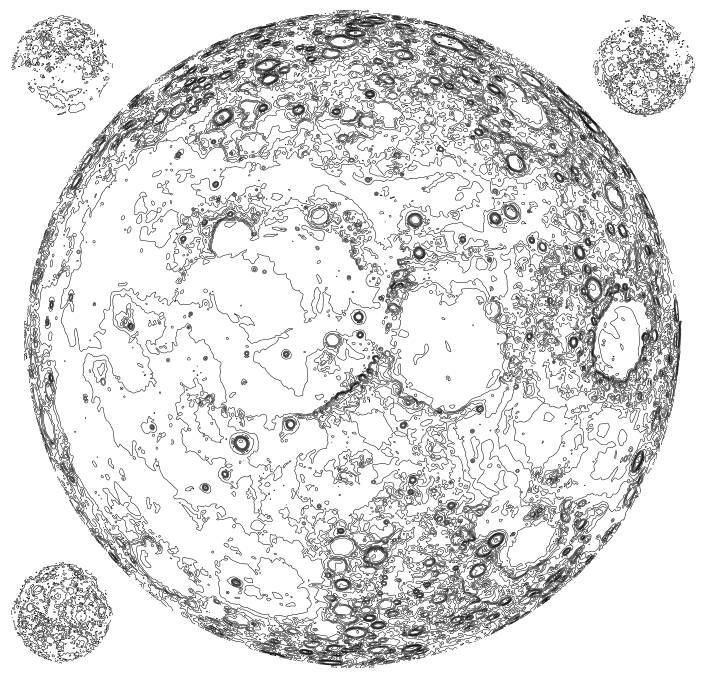

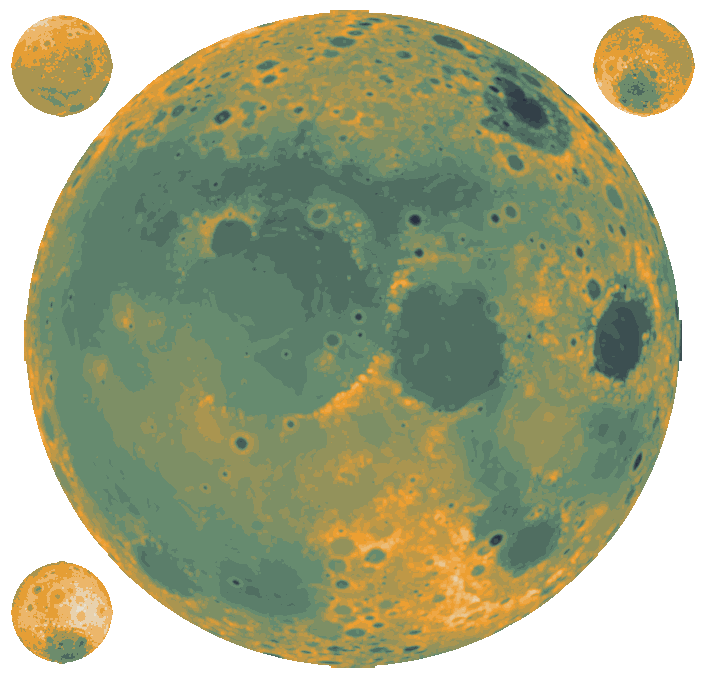

Finished plotting lines and fills for moon
Finished plotting lines and fills for venus
Finished plotting lines and fills for mars
Finished plotting lines and fills for mercury
Finished plotting lines and fills for venus_outline


In [5]:
# Plot topographic lines and colors for each planet or moon

for item in ['moon', 'venus', 'mars', 'mercury', 'venus_outline']:
    cmap = lsc.from_list("cmap", configs[item]["cmap"][::-1])
    for ii, (val, nametype) in enumerate(zip([True, False], ["lines", "colors"])):
        savename = "./figures/"+nametype+"_"+item+".png"
        if not os.path.isfile(savename): 
            fig, ax, ax1, ax2, ax3 = make_figure()
            axlist = [ax1, ax2, ax3]
            try:
                data = fill_nans(get_gdaldem(configs[item]["file_large"]), limit=configs[item]["limit"]) 
                levels = list(range(*configs[item]['levels']))
                ax = plot_gdaldem(ax, data, cmap, levels, lines=val, gauss=configs[item]["gauss"])
            except:
                pass

            for i, n in enumerate(configs[item]["file_small"]):
                data = fill_nans(get_gdaldem(n), limit=configs[item]["limit_small"])
                levels_small = list(range(*configs[item]['levels_small']))
                axlist[i] = plot_gdaldem(axlist[i], data, cmap, 
                                         levels_small, gauss=configs[item]["gauss_small"], lines=val)

            if item == 'moon':
                show = True
            else: 
                show = False
            set_save_image(fig, savename, show=show)
            
    print("Finished plotting lines and fills for "+item)

In [6]:
# Plot gridlines for orthographic map

savename = './figures/ortho_gridlines.png'
north = [0, 90]
south = [0, -90]
side = [270, 0]

fig = plt.figure(figsize=figsize)
grid = matplotlib.gridspec.GridSpec(5565, 5859)
ax = fig.add_subplot(grid[39:5565-39, 186:5859-186], projection=ccrs.Orthographic(90, 30))
ax1 = fig.add_subplot(grid[78:852+78, 78:852+78], projection=ccrs.Orthographic(*north))
ax2 = fig.add_subplot(grid[78:852+78, 5859-78-852:5859-78], projection=ccrs.Orthographic(*south))
ax3 = fig.add_subplot(grid[5565-78-852:5565-78, 78:852+78], projection=ccrs.Orthographic(*side))
ax4 = fig.add_subplot(grid[5565-78-852:5565-78, 5859-78-852:5859-78], projection=ccrs.Orthographic(*side))
    
lon_large = np.arange(0, 360, 30)
lon_small = np.arange(0, 360, 15)
lon_mini = np.arange(0, 360, 5)
lat_large = np.arange(-90, 91, 30)
lat_small = np.arange(-90, 91, 15)
lat_mini = np.arange(-90, 91, 5)
lat_delim = np.arange(-90, 90.01, 0.1)
lon_delim = np.arange(0, 360, 0.1)

for a in [ax1, ax2, ax3, ax4]:
    for lg in lat_large: 
        a.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lat_small: 
        if sm not in lat_large: 
            a.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
    for lg in lon_large: 
        a.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lon_small: 
        if sm not in lon_large: 
            a.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

for lg in lat_small: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lat_mini: 
    if sm not in lat_small: 
        ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
for lg in lon_small: 
    ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lon_mini: 
    if sm not in lon_small: 
        ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

set_save_image(fig, savename)

C:\Users\Eleanor\Anaconda3\lib\site-packages\matplotlib\colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


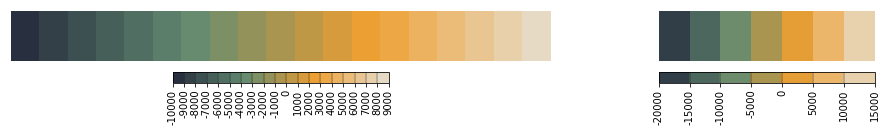

Finished plotting lines and fills for moon


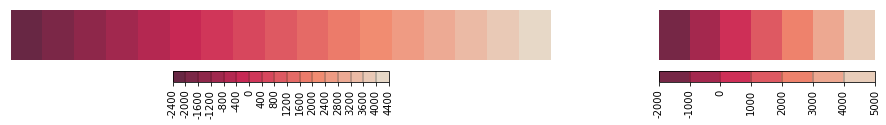

Finished plotting lines and fills for venus


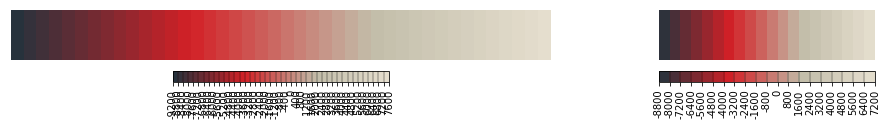

Finished plotting lines and fills for mars


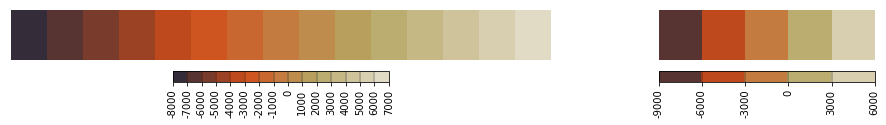

Finished plotting lines and fills for mercury


In [7]:
# Make key for topographic colors

for item in ['moon', 'venus', 'mars', 'mercury']:
    cmap = lsc.from_list("cmap", configs[item]["cmap"][::-1])
    savename = "./figures/"+item+"_key.png"
    
    fig = plt.figure(figsize=(12, 1))
    grid = matplotlib.gridspec.GridSpec(1, 8)
    ax1 = fig.add_subplot(grid[0:1, 0:5], aspect='auto')
    ax2 = fig.add_subplot(grid[0:1, 6:], aspect='auto')

    try:
        levels = list(range(*configs[item]['levels']))
        key = ax1.contourf([levels]*2, cmap=cmap, levels=levels)
        cbar = fig.colorbar(key, ax=ax1, orientation="horizontal",
                            boundaries=levels, ticks=levels, drawedges=True)
        cbar.ax.set_xticklabels(levels[::1],rotation=90)
        cbar.solids.set_edgecolor("face")
    except:
        pass
    try:
        levels_small = list(range(*configs[item]['levels_small']))
        key = ax2.contourf([levels_small]*2, cmap=cmap, levels=levels_small)
        cbar = fig.colorbar(key, ax=ax2, orientation="horizontal",
                            boundaries=levels_small, ticks=levels_small, drawedges=True)
        cbar.ax.set_xticklabels(levels_small[::1],rotation=90)
        cbar.solids.set_edgecolor("face")
    except:
        pass
    
    set_save_image(fig, savename, show=True)
    print("Finished plotting lines and fills for "+item)

In [8]:
# Make gridlines for labeling plots 
# (use Type on a Path tool in Illustrator to move names onto these lines)

savename = './figures/label_lines.pdf'

fig = plt.figure(figsize=figsize)
grid = matplotlib.gridspec.GridSpec(5565, 5859)
ax = fig.add_subplot(grid[39:5565-39, 186:5859-186], projection=ccrs.Orthographic(90, 30))
   
lats = np.arange(-90, 90, 0.5)
lon_delim = np.arange(0, 360, 0.1)
for lg in lats: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=1)

set_save_image(fig, savename)